
Unique CoC Names in clean_age_df after cleaning:
['Santa Clara' 'San Francisco' 'Alameda' 'Sacramento' 'Sonoma'
 'Contra Costa' 'Monterey' 'San Benito' 'Marin' 'Santa Cruz' 'Mendocino'
 'Stanislaus' 'San Joaquin' 'San Mateo' 'Kings' 'Tulare' 'Fresno' 'Madera'
 'Placer' 'Shasta' 'Siskiyou' 'Lassen' 'Plumas' 'Del Norte' 'Modoc'
 'Sierra' 'Napa' 'Solano' 'Butte' 'Merced' 'Yolo' 'Humboldt' 'Colusa'
 'Glenn' 'Trinity' 'El Dorado' 'Amador' 'Calaveras' 'Mariposa' 'Tuolumne'
 'Tehama' 'Lake' 'Alpine' 'Inyo' 'Mono' 'Nevada' 'Los Angeles' 'San Diego'
 'Orange' 'Santa Barbara' 'Kern' 'Riverside' 'San Bernardino' 'Ventura'
 'Imperial' 'San Luis Obispo' 'Yuba' 'Sutter']

Unique values under 'Name' in weather_df:
['Alameda' 'Alpine' 'Amador' 'Butte' 'Calaveras' 'Colusa' 'Contra Costa'
 'Del Norte' 'El Dorado' 'Fresno' 'Glenn' 'Humboldt' 'Imperial' 'Inyo'
 'Kern' 'Kings' 'Lake' 'Lassen' 'Los Angeles' 'Madera' 'Marin' 'Mariposa'
 'Mendocino' 'Merced' 'Modoc' 'Mono' 'Monterey' 'Napa' 'Nevada' 'Orange'

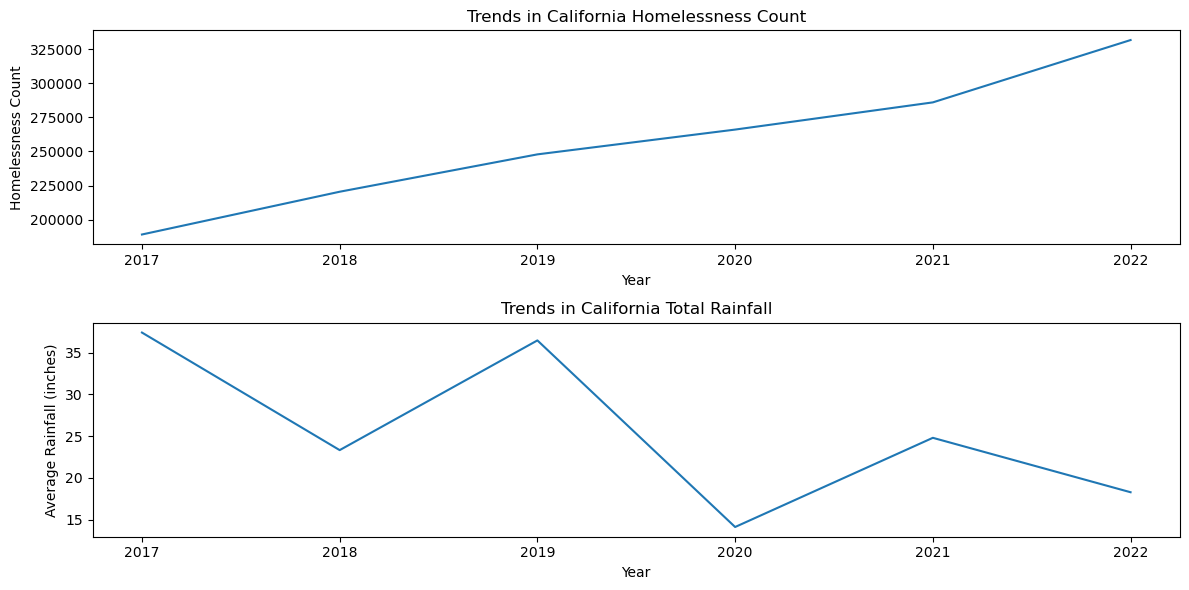

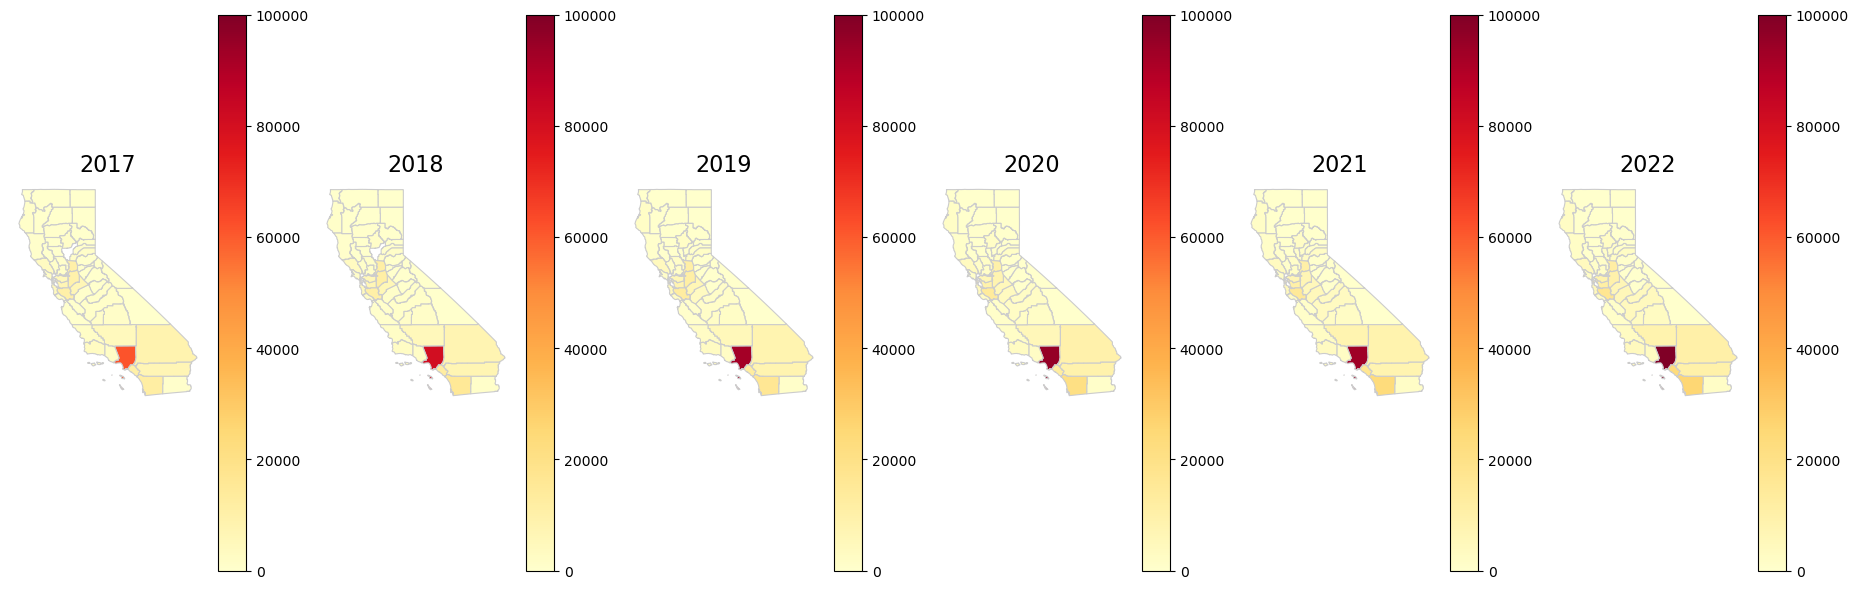

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import geopandas as gpd

# Read weather data
weather_data = Path('20172022precipitation.csv')
weather_df = pd.read_csv(weather_data)

# Clean and calculate sum of rainfall for each year
weather_df['Year'] = pd.to_datetime(weather_df['Year'], format='%Y')
weather_df['RainfallInInches'] = pd.to_numeric(weather_df['Value'], errors='coerce')
total_rainfall_per_year = weather_df.groupby(weather_df['Year'].dt.year)['RainfallInInches'].mean()

# Read age data
age_data = Path('Resources/experiencing_homelessness_age_demographics.csv')
age_df = pd.read_csv(age_data)

# Clean age data
clean_age_df = age_df.loc[age_df['EXPERIENCING_HOMELESSNESS_CNT'] != '*'].copy()
clean_age_df['EXPERIENCING_HOMELESSNESS_CNT'] = clean_age_df['EXPERIENCING_HOMELESSNESS_CNT'].astype(int)
clean_age_df['CALENDAR_YEAR'] = pd.to_datetime(clean_age_df['CALENDAR_YEAR'], format='%Y')

# Clean and standardize county names in clean_age_df and weather_df
clean_age_df['COC_NAME'] = clean_age_df['COC_NAME'].str.lower().str.strip().str.replace(' county coc', '')
clean_age_df['COC_NAME'] = clean_age_df['COC_NAME'].str.replace('san francisco coc', 'san francisco')

# Group any names containing "los angeles county" to just "los angeles"
clean_age_df.loc[clean_age_df['COC_NAME'].str.contains('los angeles county'), 'COC_NAME'] = 'los angeles'

# Filter out rows with CoC Name "california"
clean_age_df = clean_age_df[clean_age_df['COC_NAME'] != 'california']

# Remove "counties coc" from CoC names ending with it
clean_age_df.loc[:, 'COC_NAME'] = clean_age_df['COC_NAME'].str.replace(' counties coc', '')

# Capitalize the first letter of all words in "COC_NAME" field in clean_age_df
clean_age_df.loc[:, 'COC_NAME'] = clean_age_df['COC_NAME'].apply(lambda x: ' '.join(word.capitalize() for word in x.split()))

# Function to split CoC names and divide homeless counts
def split_coc_and_divide_counts(row):
    coc_name = row['COC_NAME']
    counties = coc_name.split(', ')
    num_counties = len(counties)
    homeless_count = row['EXPERIENCING_HOMELESSNESS_CNT']
    divided_count = homeless_count / num_counties
    
    data = {'CALENDAR_YEAR': row['CALENDAR_YEAR'], 'COC_NAME': counties, 'EXPERIENCING_HOMELESSNESS_CNT': divided_count}
    return pd.DataFrame(data)

# Split CoC names and divide homeless counts
clean_age_df = pd.concat(clean_age_df.apply(split_coc_and_divide_counts, axis=1).tolist(), ignore_index=True)

# Capitalize the first letter of all words in "Name" field in weather_df and remove " County" from the end
weather_df['Name'] = weather_df['Name'].str.lower().str.strip().str.replace(' county', '').apply(lambda x: ' '.join(word.capitalize() for word in x.split()))

# Get a list of all unique CoC Name values in clean_age_df after cleaning
unique_coc_names = clean_age_df['COC_NAME'].unique()
print("\nUnique CoC Names in clean_age_df after cleaning:")
print(unique_coc_names)

# Get a list of all unique values under the "Name" column in weather_df
unique_weather_names = weather_df['Name'].unique()
print("\nUnique values under 'Name' in weather_df:")
print(unique_weather_names)

# Group by year and sum homeless counts
total_homeless_count = clean_age_df.groupby(clean_age_df['CALENDAR_YEAR'].dt.year)['EXPERIENCING_HOMELESSNESS_CNT'].sum()

# Plot trends in homelessness count and total rainfall for each year
plt.figure(figsize=(12, 6))

# Plot 1: Homelessness Count
plt.subplot(2, 1, 1)
plt.plot(total_homeless_count.index, total_homeless_count.values)
plt.xlabel('Year')
plt.ylabel('Homelessness Count')
plt.title('Trends in California Homelessness Count')

# Plot 2: Total Rainfall
plt.subplot(2, 1, 2)
plt.plot(total_rainfall_per_year.index, total_rainfall_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average Rainfall (inches)')
plt.title('Trends in California Total Rainfall')

plt.tight_layout()
plt.show()



# Function to create the choropleth map for a specific year
def create_choropleth_map(year, ax):
    # Sum the homeless count grouped by year and county (CoC Name)
    clean_age_df_grouped = clean_age_df.groupby(['CALENDAR_YEAR', 'COC_NAME'], as_index=False)['EXPERIENCING_HOMELESSNESS_CNT'].sum()

    # Capitalize the first letter of all words in "COC_NAME" field in clean_age_df
    clean_age_df_grouped['COC_NAME'] = clean_age_df_grouped['COC_NAME'].apply(lambda x: ' '.join(word.capitalize() for word in x.split()))

    # Filter data for the specific year
    clean_age_df_filtered = clean_age_df_grouped[clean_age_df_grouped['CALENDAR_YEAR'].dt.year == year]

    # Merge homeless counts with California county boundaries data (same as before)
    california_counties = gpd.read_file('california_counties.geojson')

    # Capitalize the first letter of all words in "name" field in california_counties
    california_counties['name'] = california_counties['name'].apply(lambda x: ' '.join(word.capitalize() for word in x.split()))

    # Merge data with county boundaries
    merged_df = pd.merge(california_counties, clean_age_df_filtered, left_on='name', right_on='COC_NAME', how='left')

    # Plot the choropleth map with fixed range for legend
    mappable = merged_df.plot(column='EXPERIENCING_HOMELESSNESS_CNT', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', legend=True, vmin=0, vmax=100000, ax=ax)

    # Update the title and place the Year number below "Homeless Count by County"
    ax.set_title(f'Homeless Count by County\nYear - {year}', pad=20)

    ax.set_axis_off()
    return mappable  # Return the mappable object


# Create choropleth maps for each year
years = [2017, 2018, 2019, 2020, 2021, 2022]
fig, axs = plt.subplots(1, len(years), figsize=(20, 6), sharey=True)
mappables = []  # List to store the mappable objects for colorbar

for i, year in enumerate(years):
    mappable = create_choropleth_map(year, axs[i])
    mappables.append(mappable)
    axs[i].set_title(str(year), fontsize=16)  # Set title to just the year

# Position the legend outside the plot area
plt.tight_layout()

# Create a single colorbar for all maps
fig.subplots_adjust(right=0.9)
#cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#cbar = fig.colorbar(mappables[0].get_children()[0], cax=cbar_ax)
#cbar.set_label('Homeless Count by County', fontsize=14)  # Set the colorbar label

plt.show()

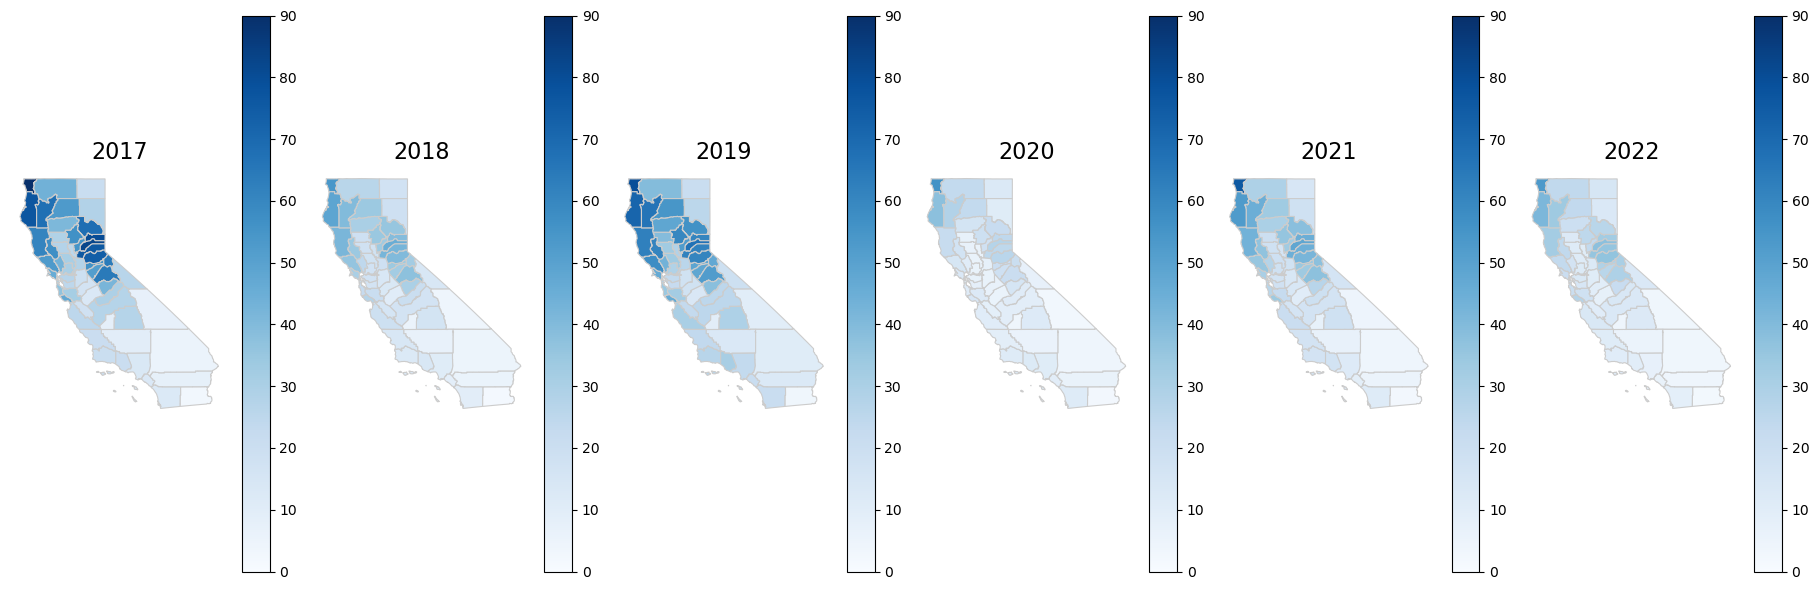

In [5]:
def create_precipitation_choropleth(year, ax):
    # Filter weather data for the specific year
    weather_df_filtered = weather_df[weather_df['Year'].dt.year == year]

    # Group weather data by county and calculate average precipitation
    avg_precip_by_county = weather_df_filtered.groupby('Name')['RainfallInInches'].mean().reset_index()

    # Merge average precipitation data with California county boundaries data
    california_counties = gpd.read_file('california_counties.geojson')
    merged_df = pd.merge(california_counties, avg_precip_by_county, left_on='name', right_on='Name', how='left')

    # Plot the choropleth map with fixed range for legend
    mappable = merged_df.plot(column='RainfallInInches', cmap='Blues', linewidth=0.8, edgecolor='0.8', legend=True, vmin=0, vmax=90, ax=ax)

    # Update the title and place the Year number below "Precipitation by County"
    ax.set_title(f'Precipitation by County\nYear - {year}', pad=20)

    # Remove boxes with tick marks
    ax.set_axis_off()

    return mappable  # Return the mappable object


# Create precipitation choropleth maps for each year
years = [2017, 2018, 2019, 2020, 2021, 2022]
fig, axs = plt.subplots(1, len(years), figsize=(20, 6), sharey=True)
mappables_precip = []  # List to store the mappable objects for precipitation colorbar

for i, year in enumerate(years):
    mappable_precip = create_precipitation_choropleth(year, axs[i])
    mappables_precip.append(mappable_precip)
    axs[i].set_title(f'Homeless Count by County\nYear - {year}', fontsize=16)  # Set title to just the year for homeless count
    axs[i].set_title(str(year), fontsize=16)  # Set title to just the year for precipitation

# Position the legend outside the plot area
plt.tight_layout()

# Create a single colorbar for precipitation
fig.subplots_adjust(right=0.9)
#cbar_ax_precip = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#cbar_precip = fig.colorbar(mappables_precip[0].get_children()[0], cax=cbar_ax_precip)
#cbar_precip.set_label('Average Precipitation (inches)', fontsize=14)  # Set the precipitation colorbar label

# Show the plots
plt.show()